# Import librairies et jeux de données

In [1]:
import pandas as pd
import numpy as np

#pour les représentations graphiques
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#pour centrer-réduire
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#pour les test statistiques
from scipy.stats import ttest_ind, shapiro

#pour les modèles non-supervisés
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#pour les modèles supervisés
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split

#Pour évaluer les performances des modèles
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_percentage_error, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from scipy.optimize import linear_sum_assignment

In [2]:
df_scaled = pd.read_csv("df_scaled_MinMaxScaler.csv", sep=',')
df = pd.read_csv("df.csv", sep=',')

# Clustering

## Application du Kmeans

In [3]:
#on supprime la colonne is_genuine
df_kmeans = df_scaled.drop(columns='is_genuine')
df_kmeans.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,0.390863,0.988506,1.000000,0.392857,0.378049,0.674747
1,0.213198,0.126437,0.394366,0.201531,0.439024,0.727273
2,0.837563,0.770115,0.319249,0.362245,0.408537,0.741414
3,0.162437,0.442529,0.525822,0.163265,0.451220,0.812121
4,0.350254,0.655172,0.300469,0.270408,0.737805,0.616162


Sachant que l'on cherche à dvisier nos individus selon 2 modalités (vrai/faux billet), j'effectue mon kmeans pour 2 clusters.

In [4]:
# On instancie notre Kmeans avec 2 clusters : 
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)

# On l'entraine : 
kmeans.fit(df_kmeans)

# On peut stocker nos clusters dans une variable labels : 
labels = kmeans.labels_
labels

array([1, 0, 0, ..., 1, 1, 1])

In [5]:
#creer une colonne pour mettre les clusters generés et ré-intégrer la colonne is_genuine
df_kmeans['label_kmeans'] = labels
df_kmeans['is_genuine'] = df['is_genuine']
df_kmeans.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,label_kmeans,is_genuine
0,0.390863,0.988506,1.000000,0.392857,0.378049,0.674747,1,1
1,0.213198,0.126437,0.394366,0.201531,0.439024,0.727273,0,1
2,0.837563,0.770115,0.319249,0.362245,0.408537,0.741414,0,1
3,0.162437,0.442529,0.525822,0.163265,0.451220,0.812121,0,1
4,0.350254,0.655172,0.300469,0.270408,0.737805,0.616162,0,1


In [6]:
df_kmeans['label_kmeans'].value_counts()

0    1005
1     495
Name: label_kmeans, dtype: int64

## Tableau de contingence

A cette étape, nous voulons nous assurer que chaque cluster obtenu avec le kmeans correspond bien à la même catégorie de la colonne is_genuine.

In [7]:
#Création des listes de clusters
list_label_is_genuine = list(int(label) for label in df_kmeans['is_genuine'])
list_label_kmeans = list(int(label) for label in df_kmeans['label_kmeans'])

In [8]:
# Je crée une matrice de confusion entre les deux clusterings
conf_mat = confusion_matrix(list_label_is_genuine, list_label_kmeans)

# Je cherche l’appariement optimal
row_ind, col_ind = linear_sum_assignment(-conf_mat)  # le "-" car c'est un problème de maximisation

# Je crée un mapping entre les labels
label_mapping = {col: row for row, col in zip(row_ind, col_ind)}

# Je recalibre les labels KMeans
aligned_kmeans_labels = np.array([label_mapping[label] for label in list_label_kmeans])

#j'attribue les nouveaux clusters
df_kmeans['label_kmeans'] = aligned_kmeans_labels

In [9]:
df_kmeans['label_kmeans'].value_counts()

1    1005
0     495
Name: label_kmeans, dtype: int64

In [10]:
y_pred = df_kmeans['label_kmeans'].astype(int)
y_true = df_kmeans['is_genuine'].astype(int)

# Puis affiche la matrice
cm = confusion_matrix(y_true, y_pred)
cm

array([[488,  12],
       [  7, 993]], dtype=int64)

In [11]:
df_kmeans.loc[(df_kmeans['label_kmeans'] == 1) & (df_kmeans['is_genuine'] == 0)].count()

diagonal        12
height_left     12
height_right    12
margin_low      12
margin_up       12
length          12
label_kmeans    12
is_genuine      12
dtype: int64

In [12]:
df_kmeans.loc[(df_kmeans['label_kmeans'] == 0) & (df_kmeans['is_genuine'] == 1)].count()

diagonal        7
height_left     7
height_right    7
margin_low      7
margin_up       7
length          7
label_kmeans    7
is_genuine      7
dtype: int64

## Calcul des centroïdes

In [13]:
df_kmeans.drop(columns='is_genuine', inplace=True)
mean_values_kmeans = df_kmeans.groupby('label_kmeans').mean()
mean_values_kmeans

,diagonal,height_left,height_right,margin_low,margin_up,length
label_kmeans,,,,,,
0,0.436446,0.609033,0.624736,0.572920,0.658672,0.431107
1,0.480875,0.463053,0.463303,0.289995,0.477794,0.749069


## Exemple avec un nouveau billet

In [14]:
nouveau_billet = np.array([[0.48, 0.46, 0.46, 0.28, 0.48, 0.75]])

In [15]:
# Prédiction du cluster
cluster = kmeans.predict(nouveau_billet)

C:\Users\Pauline NANDELEC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [16]:
cluster

array([0])

Sachant que lors de l'entrainement de Kmeans, 0 correspondant aux vrais billets et 1 aux faux billets, ce billet est vrai.

# Régression logistique

In [17]:
df_scaled.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,0.390863,0.988506,1.000000,0.392857,0.378049,0.674747
1,1,0.213198,0.126437,0.394366,0.201531,0.439024,0.727273
2,1,0.837563,0.770115,0.319249,0.362245,0.408537,0.741414
3,1,0.162437,0.442529,0.525822,0.163265,0.451220,0.812121
4,1,0.350254,0.655172,0.300469,0.270408,0.737805,0.616162


In [18]:
df_scaled.loc[df_scaled['is_genuine'] == 0].head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1000,0,0.629442,0.465517,0.511737,0.459184,0.634146,0.385859
1001,0,0.446701,0.413793,0.694836,0.505102,0.524390,0.363636
1002,0,0.279188,0.574713,0.732394,0.507653,0.731707,0.349495
1003,0,0.497462,0.683908,0.708920,0.563776,0.573171,0.505051
1004,0,0.766497,0.637931,0.661972,0.668367,0.524390,0.450505


## Entraînement du modèle

In [19]:
#définition X et y
X = df_scaled.drop(columns='is_genuine').to_numpy()
y = df_scaled['is_genuine'].to_numpy()

In [20]:
#séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [21]:
#initialisation et entraînement du modèle
clf = LogisticRegression(random_state=808).fit(X_train, y_train)

In [22]:
# Prediction d'un échantillon
print("Prédiction",clf.predict([X[1000, :]])[0])

print("Probabilité",clf.predict_proba([X[1000, :]])[0][0])

Prédiction 0
Probabilité 0.8251764683965908


Soit 82.51 % de chance d'appartenir à la classe 0.

In [23]:
print("Classe réelle du billet: ", y[1000])

Classe réelle du billet:  0


In [24]:
# Prediction d'un échantillon
print("Prédiction",clf.predict([X[0, :]])[0])

print("Probabilité",clf.predict_proba([X[0, :]])[0][0])

Prédiction 0
Probabilité 0.548270186188744


Soit 54.83 % de chance d'appartenir à la classe 0.

In [25]:
print("Classe réelle du billet: ", y[0])

Classe réelle du billet:  1


## Mesures de perfomance

<Axes: ylabel='Count'>

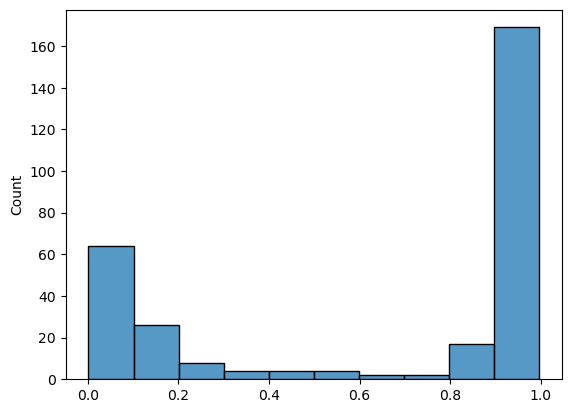

In [26]:
#histogramme des probabilités de prédiction
y_hat_proba = clf.predict_proba(X_test)[:,1]
sns.histplot(y_hat_proba)

Le modèle est assez confiant de ses prédiction, la plupart des prédictions ont une probabilité proche de 0 ou de 1

In [27]:
#Accuracy 
y_pred = clf.predict(X_test)

print("accuracy",accuracy_score(y_test, y_pred))

accuracy 0.9866666666666667


L'accuracy mesure le nombre d'échantillons qui ont été bien classés sur le nombre d'échantillons total. 98.7% est un très bon score.

In [28]:
#matrice de confusion

confusion_matrix(y_test, y_pred)

array([[106,   4],
       [  0, 190]], dtype=int64)

4 faux positifs (faux billets classés comme vrais billets)

## Test avec d'autres seuils de classification

Dans le cas de la détection de fraude, il y a un fort déséquilibre entre les cas positifs et les cas négatifs dans le dataset.
On obtient ici une accuracy de 98.7% mais il faut faire intervenir d'autres métriques de classification adaptées à ce type de situation pour adapter notre modèle.

In [29]:
y_hat_proba = clf.predict_proba(X_test)[:,1]

In [30]:
#On obtient les catégories relatives pour les 2 seuils :
y_pred_03 = [ 0 if value < 0.3 else 1 for value in y_hat_proba ]
y_pred_07 = [ 0 if value < 0.7 else 1 for value in y_hat_proba ]

In [31]:
#On a alors les matrices de confusion suivantes :

#pour 0.3:
confusion_matrix(y_test, y_pred_03)

array([[ 98,  12],
       [  0, 190]], dtype=int64)

12 faux positifs (faux billets classés comme vrais billets)

In [32]:
#pour 0.7:
confusion_matrix(y_test, y_pred_07)

array([[109,   1],
       [  3, 187]], dtype=int64)

1 faux positif (faux billet classé comme vrai) et 3 faux négatifs (vrais billets classés comme faux)

In [33]:
#Autres métriques de classification
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))

Accuracy: 0.9866666666666667
Precision: 0.979381443298969
Recall: 1.0


In [34]:
print("Accuracy:",accuracy_score(y_test, y_pred_03))
print("Precision:",precision_score(y_test, y_pred_03))
print("Recall:",recall_score(y_test, y_pred_03))

Accuracy: 0.96
Precision: 0.9405940594059405
Recall: 1.0


In [35]:
print("Accuracy:",accuracy_score(y_test, y_pred_07))
print("Precision:",precision_score(y_test, y_pred_07))
print("Recall:",recall_score(y_test, y_pred_07))

Accuracy: 0.9866666666666667
Precision: 0.9946808510638298
Recall: 0.9842105263157894


Text(0.5, 1.0, 'ROC curve 0.5')

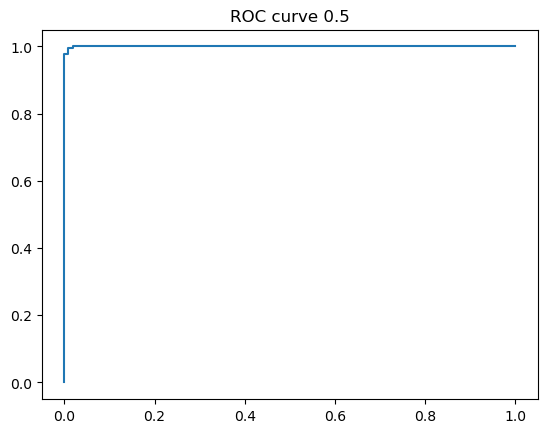

In [36]:
#On peut tracer la courbe ROC pour visualiser cela.

#Pour seuil de classification = 0.5
fpr, tpr, thresholds = roc_curve(y_test, y_hat_proba)
plt.plot(fpr, tpr)
plt.title("ROC curve 0.5")

Text(0.5, 1.0, 'ROC curve 0.3')

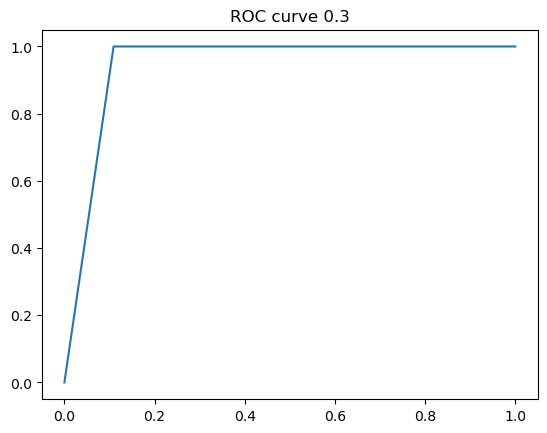

In [37]:
#Pour seuil de classification = 0.3
fpr, tpr, thresholds = roc_curve(y_test, y_pred_03)
plt.plot(fpr, tpr)
plt.title("ROC curve 0.3")

Text(0.5, 1.0, 'ROC curve 0.7')

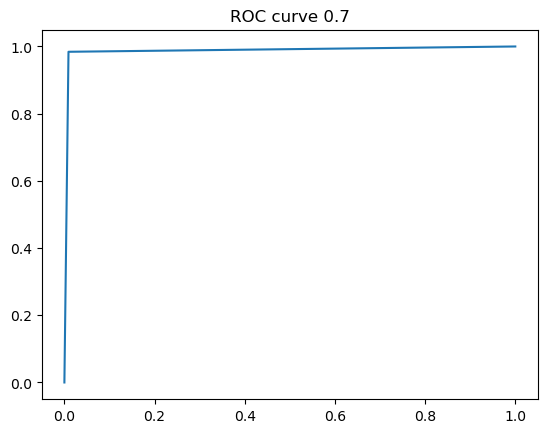

In [38]:
#Pour seuil de classification = 0.7
fpr, tpr, thresholds = roc_curve(y_test, y_pred_07)
plt.plot(fpr, tpr)
plt.title("ROC curve 0.7")

"Plus la courbe se rapproche du coin en haut à gauche, meilleur est le modèle.": le meilleur modèle est donc celui avec le seuil de classification 0.7.